In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mlt
import warnings
import glob
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.impute import SimpleImputer




STEP. 01. IMPLEMENTING DATA AUGMENTATION TECHNIQUES.

I HAVE CONSIDERED SEVEN TECHNIQUES:
1. JITTER
2. RESAMPLE
3. TIME WARPING
4. MAGNITUDE WARPING
5. CROPPING
6. PERMUTATION
7. ROTATION


In [8]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [9]:
#1.1. JITTER DATA AUGMENTATION TECHNIQUES.
def MHealth_Jitter_Tech(MHealth_Data_Jitter, sigma=0.01):
    MHealth_Integer_Values = MHealth_Data_Jitter.select_dtypes(include=[np.number])
    noise = np.random.normal(loc=0, scale=sigma, size=MHealth_Integer_Values.shape)
    MHealth_Jittered_Data = MHealth_Integer_Values + noise
    return MHealth_Jittered_Data

In [10]:
#1.2. RESAMPLING DATA AUGMENTATION TECHNIQUES.
def MHealth_Resample_Data(MHealth_Data_Resample, Resample_New_Length):
    MHealth_Integer_Values = MHealth_Data_Resample.select_dtypes(include=[np.number])
    MHealth_Resample_Data = MHealth_Integer_Values.apply(lambda x: np.interp(np.linspace(0, len(x) - 1, Resample_New_Length), np.arange(len(x)), x))
    return pd.DataFrame(MHealth_Resample_Data, columns=MHealth_Integer_Values.columns)


In [11]:
#1.3. TIME WRAPPING DATA AUGMENTATION TECHNIQUES.
def MHealth_Time_Warp_Data(MHealth_Data_Time_Warp, sigma=0.2):
    # Considering only integers
    MHealth_Interger_Values = MHealth_Data_Time_Warp.select_dtypes(include=[np.number])
    warp = np.cumsum(np.random.normal(loc=1.0, scale=sigma, size=len(MHealth_Interger_Values)))
    warp = warp / warp[-1]
    Time_Warped_Data = pd.DataFrame()
    for col in MHealth_Interger_Values.columns:
        Time_Warped_Data[col] = np.interp(np.linspace(0, 1, len(MHealth_Interger_Values)), warp, MHealth_Interger_Values[col])
    return Time_Warped_Data


In [12]:
#1.4. MAGNITUDE WRAP DATA AUGMENTATION TECHNIQUES.
def MHealth_Magnitude_Warp_Data(MHealth_Data_Magnitude_Warp, sigma=0.2):
    # only integers
    MHealth_Interger_Value = MHealth_Data_Magnitude_Warp.select_dtypes(include=[np.number])
    MHealth_Magnitude_Warp = np.random.normal(loc=1.0, scale=sigma, size=MHealth_Interger_Value.shape)
    MHealth_Magnitude_Warped_Data = MHealth_Interger_Value * MHealth_Magnitude_Warp
    return MHealth_Magnitude_Warped_Data

In [13]:
#1.5. CROPPING DATA AUGMENTATION TECHNIQUES.
def MHealth_Crop_Data(MHealth_Data_Crop, crop_fraction=0.1):
    MHealth_Interger_Value = MHealth_Data_Crop.select_dtypes(include=[np.number])
    MHealth_Num_To_Crop = int(len(MHealth_Interger_Value) * crop_fraction)
    start = np.random.randint(0, len(MHealth_Interger_Value) - MHealth_Num_To_Crop)
    MHealth_Cropped_Data = MHealth_Interger_Value.iloc[start:start+MHealth_Num_To_Crop].reset_index(drop=True)
    return MHealth_Cropped_Data

In [14]:
#1.6. PERMUTATION DATA AUGMENTATION TECHNIQUES.
def MHealth_Permutation_Data(MHealth_Data_Permute,Permute_Num_Segments=4):
    # Select only numeric values and calculate segment length
    MHealth_Integer_Value = MHealth_Data_Permute.select_dtypes(include=[np.number])
    MHealth_Permute_Length = len(MHealth_Integer_Value) // Permute_Num_Segments
    Permuted_Remainder = len(MHealth_Integer_Value) % Permute_Num_Segments
    Permuted_Segments = []
    # Splitting the data into segments
    for i in range(Permute_Num_Segments):
        start_idx = i * MHealth_Permute_Length
        end_idx = (i + 1) * MHealth_Permute_Length
        if i == Permute_Num_Segments - 1:  # Add the remainder to the last segment
            end_idx += Permuted_Remainder
        Permuted_Segments.append(MHealth_Integer_Value.iloc[start_idx:end_idx])
    np.random.shuffle(Permuted_Segments)
    MHealth_Permuted_Data = pd.concat(Permuted_Segments).reset_index(drop=True)
    
    return MHealth_Permuted_Data

In [15]:
#1.7. ROTATING DATA AUGMENTATION TECHNIQUES.
def MHealth_Rotate_Data(MHealth_Data_Rotated, angle=15):
    MHealth_Interger_Value = MHealth_Data_Rotated.select_dtypes(include=[np.number])
    rotation_matrix = np.array([[np.cos(np.radians(angle)), -np.sin(np.radians(angle))],
                                [np.sin(np.radians(angle)), np.cos(np.radians(angle))]])
    Rotation_Augmented_Data = np.dot(MHealth_Interger_Value.iloc[:, :2], rotation_matrix)
    Rotate_Result = MHealth_Interger_Value.copy()
    Rotate_Result.iloc[:, :2] = Rotation_Augmented_Data
    return Rotate_Result

In [16]:
#1.8 Creating saveDataToCSV in order to save the all augmented files accordingly.
MHealth_Cleaned_Dataset = pd.read_csv('./MHealth Dataset/Data/BaseFiles/MHealth_Cleaned_Dataset.csv')
def saveDataToCSV(ModelsName):
    MHealth_Cleaned_Dataset_Augmented = MHealth_Cleaned_Dataset.copy()
    match ModelsName:
        case 'JITTER':
            MHealth_Cleaned_Dataset_Augmented.update(MHealth_Jitter_Tech(MHealth_Cleaned_Dataset, sigma=0.01))
        case 'RESAMPLING':
            MHealth_Cleaned_Dataset_Augmented.update(MHealth_Resample_Data(MHealth_Cleaned_Dataset, Resample_New_Length=100))
        case 'TIME WRAPPING':
            MHealth_Cleaned_Dataset_Augmented.update(MHealth_Time_Warp_Data(MHealth_Cleaned_Dataset_Augmented))
        case 'MAGNITUDE WRAPPING':
            MHealth_Cleaned_Dataset_Augmented.update(MHealth_Magnitude_Warp_Data(MHealth_Cleaned_Dataset))
        case 'CROP DATA':
            MHealth_Cleaned_Dataset_Augmented.update(MHealth_Crop_Data(MHealth_Cleaned_Dataset))
        case 'PERMUTATION':
            MHealth_Cleaned_Dataset_Augmented.update(MHealth_Permutation_Data(MHealth_Cleaned_Dataset) )
        case 'ROTATION':
            MHealth_Cleaned_Dataset_Augmented.update(MHealth_Rotate_Data(MHealth_Cleaned_Dataset))
    MHealth_Cleaned_Dataset_Augmented.to_csv('./MHealth Dataset/Data/Traditional/MHealth_Cleaned_Dataset_Augmented_'+ModelsName+'.csv', index=False, float_format='%.2f')

In [17]:
#1.9. Calling functions
saveDataToCSV('JITTER')
saveDataToCSV('RESAMPLING')
saveDataToCSV('TIME WRAPPING')
saveDataToCSV('MAGNITUDE WRAPPING')
saveDataToCSV('CROP DATA')
saveDataToCSV('PERMUTATION')
saveDataToCSV('ROTATION')

In [18]:
#2  Combining all augmented data in sinle file, following to check null and duplicates records.
pattern = './MHealth Dataset/Data/Traditional/MHealth_Cleaned_Dataset_Augmented_*.csv'
files = glob.glob(pattern)
MasterData = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)
MasterData.to_csv('./MHealth Dataset/Data/Traditional/MHealth_Cleaned_Dataset_Traditional_Augmented.csv', index=False, float_format='%.2f')
print(MasterData.shape)


(350000, 25)


In [19]:
DuplicateValues = MasterData.duplicated().sum()
print(f"Number of duplicates in the augmented dataset: {DuplicateValues}")
NullValues = MasterData.isnull().sum().sum()
print(f"Number of null values in the augmented dataset: {NullValues}")
if DuplicateValues == 0 and NullValues == 0:
    print("No duplicates or null values found.We are good to proceed!")
else:
    print("Duplicates or null values found.")

MasterData = MasterData.drop_duplicates()
print(f"Shape after removing duplicates: {MasterData.shape}")

Number of duplicates in the augmented dataset: 97676
Number of null values in the augmented dataset: 0
Duplicates or null values found.
Shape after removing duplicates: (252324, 25)


In [42]:
MasterData = pd.read_csv('./MHealth Dataset/Data/Traditional/MHealth_Cleaned_Dataset_Traditional_Augmented.csv')
MHealth_X_Data = MasterData.drop(columns=['Activity'])
MHealth_Y_Data = MasterData['Activity']
MHealth_Label_Encoder = LabelEncoder()
MHealth_Y_Data_Encoded = MHealth_Label_Encoder.fit_transform(MHealth_Y_Data)

# Spliting augmented data into 80% for training and 20% for test
MasterData_X_Train, MasterData_X_Test, MasterData_Y_Train, MasterData_Y_Test = train_test_split(
    MHealth_X_Data, MHealth_Y_Data_Encoded, test_size=0.2, random_state=42, stratify=MHealth_Y_Data_Encoded)
non_numeric_columns = MasterData_X_Train.select_dtypes(include=['object']).columns

for i in non_numeric_columns:
    le = LabelEncoder()
    MasterData_X_Train[i] = le.fit_transform(MasterData_X_Train[i])
    MasterData_X_Test[i] = le.transform(MasterData_X_Test[i])
label_encoder = LabelEncoder()
MasterData_Y_Train_encoded = label_encoder.fit_transform(MasterData_Y_Train)
print("MHealth dataset has been splitted successfully.")

MHealth dataset has been splitted successfully.


,ACTIVITY,HEADCOUNTS
0,7,199478
1,3,7566
2,10,7470
3,6,7420
4,8,7330
5,9,7330
6,4,7286
7,12,7051
8,0,6966
9,2,6815


,ACTIVITY,HEADCOUNTS
0,7,199478
1,11,199478
2,1,199478
3,8,199478
4,9,199478
5,2,199478
6,6,199478
7,3,199478
8,12,199478
9,4,199478


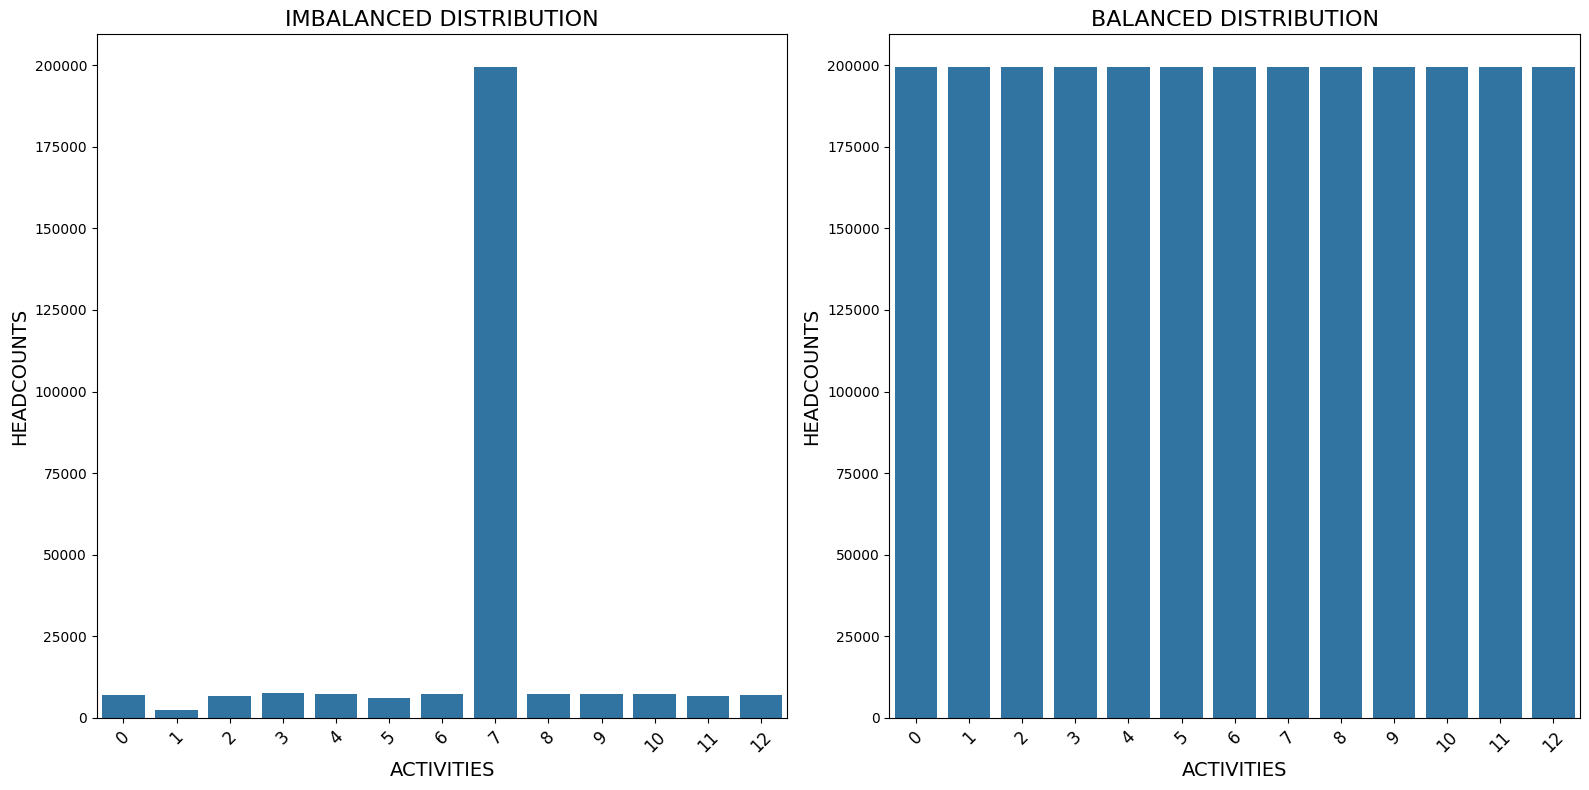

In [43]:
# Initialize SMOTE and apply it to balance the training set
MHealth_Trad_Smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced_encoded = MHealth_Trad_Smote.fit_resample(MasterData_X_Train, MasterData_Y_Train_encoded)
y_train_balanced = label_encoder.inverse_transform(y_train_balanced_encoded)
X_train_balanced.to_csv('./MHealth Dataset/Data/Traditional/MHealth_Traditional_Train_Balanced_Agumented.csv', index=False, float_format='%.2f')
y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=['Activity'])
y_train_balanced_df.to_csv('./MHealth Dataset/Data/Traditional/MHealth_Traditional_Train_Labels_Balanced.csv', index=False)
MasterData_Y_Train_series = pd.Series(MasterData_Y_Train)
Imbalance_Distribution_DataFrame = pd.DataFrame(MasterData_Y_Train_series.value_counts()).reset_index()
Imbalance_Distribution_DataFrame.columns = ['ACTIVITY', 'HEADCOUNTS']
Balanced_Distribution_DataFrame = pd.DataFrame(y_train_balanced_df['Activity'].value_counts()).reset_index()
Balanced_Distribution_DataFrame.columns = ['ACTIVITY', 'HEADCOUNTS']

Imbalance_Distribution_Display = Imbalance_Distribution_DataFrame.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
).format(precision=2).set_caption("IMBALANCE DISTRIBUTION")

Balanced_Distribution_Display = Balanced_Distribution_DataFrame.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
).format(precision=2).set_caption("BALANCED DISTRIBUTION")
display(Imbalance_Distribution_Display)
display(Balanced_Distribution_Display)

# Plotting the graph to compare balanced and imbalanced data
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
sns.countplot(x=MasterData_Y_Train_series, ax=axs[0])
axs[0].set_title('IMBALANCED DISTRIBUTION', fontsize=16)
axs[0].set_xlabel('ACTIVITIES', fontsize=14)
axs[0].set_ylabel('HEADCOUNTS', fontsize=14)
axs[0].tick_params(axis='x', rotation=45, labelsize=12)

# Plot for Balanced Distribution
sns.countplot(x=y_train_balanced_df['Activity'], ax=axs[1])
axs[1].set_title('BALANCED DISTRIBUTION', fontsize=16)
axs[1].set_xlabel('ACTIVITIES', fontsize=14)
axs[1].set_ylabel('HEADCOUNTS', fontsize=14)
axs[1].tick_params(axis='x', rotation=45, labelsize=12)

plt.tight_layout()
plt.show()

In [47]:
def trainAndtestdatasheet(modelsName, MasterData_X_Train, MasterData_X_Test):
    if modelsName == 'LSTM':
        MHealth_X_Train = np.expand_dims(MasterData_X_Train, axis=1)
        MHealth_X_Test  = np.expand_dims(MasterData_X_Test, axis=1)
    else:
        MHealth_X_Train = np.expand_dims(MasterData_X_Train, axis=-1)
        MHealth_X_Test  = np.expand_dims(MasterData_X_Test, axis=-1)

    return MHealth_X_Train, MHealth_X_Test


In [48]:
#Consolidating all results in single csv(accuracy,F1 Score)
def getAccuracyAndF1Score(Base,ModelName,Accuracy,F1Score):
    if not os.path.exists('./MHealth Dataset/results'):
        os.makedirs('./MHealth Dataset/results')

    result = {
        "Methodolgy":Base,
        "Model": ModelName,
        "Accuracy": Accuracy,
        "F1 Score": F1Score
    }
    file_path = './MHealth Dataset/results/results.csv'
    df_result = pd.DataFrame([result])
    if os.path.exists(file_path):
        df_result.to_csv(file_path, mode='a', header=False, index=False)
    else:
        df_result.to_csv(file_path, mode='w', header=True, index=False)
        print(f"File {file_path} created and results logged.")

In [49]:
def TrainingModelAndGeneratingReport(TrainingModelName,ModelsName):
    ModelAccuracy = 0.0
    ModelClassificationDataFrame = pd.DataFrame
    MHealth_X_Train, MHealth_X_Test = trainAndtestdatasheet(ModelsName,MasterData_X_Train, MasterData_X_Test)
    if (ModelsName =='LSTM' or ModelsName =='CNN'):  
        TrainingModelName.fit(MHealth_X_Train, MasterData_Y_Train, epochs=10,batch_size=32,validation_data=(MHealth_X_Test, MasterData_Y_Test), callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)])
        MHealth_Evaluation = TrainingModelName.evaluate(MHealth_X_Test, MasterData_Y_Test)
        ModelPrediction = np.argmax(TrainingModelName.predict(MHealth_X_Test), axis=-1)
        ModelClassificationReport = classification_report(MasterData_Y_Test, ModelPrediction, output_dict=True)
        ModelClassificationDataFrame = pd.DataFrame(ModelClassificationReport).transpose()
        ModelClassificationDataFrame.loc['accuracy'] = [MHealth_Evaluation[1] * 100, '-', '-', '-']
        ModelAccuracy = accuracy_score(MasterData_Y_Test, ModelPrediction) * 100
        ModelF1Score = f1_score(MasterData_Y_Test, ModelPrediction, average='weighted')
    else:
        TrainingModelName.fit(MasterData_X_Train, MasterData_Y_Train)
        ModelPrediction = TrainingModelName.predict(MasterData_X_Test)
        ModelAccuracy = accuracy_score(MasterData_Y_Test, ModelPrediction) * 100
        ModelF1Score = f1_score(MasterData_Y_Test, ModelPrediction, average='weighted')
        ModelClassificationReport = classification_report(MasterData_Y_Test, ModelPrediction, output_dict=True)
        ModelClassificationDataFrame = pd.DataFrame(ModelClassificationReport).transpose()
        ModelClassificationDataFrame.loc['accuracy'] = [ModelAccuracy, '-', '-', '-']
    getAccuracyAndF1Score('Traditional Class',ModelsName,ModelAccuracy,ModelF1Score)
    ModelClassificationDataFrame = ModelClassificationDataFrame.round(2)
    ModelClassificationDataFrame.columns = [col.upper() for col in ModelClassificationDataFrame.columns]
    ModelClassificationDataFrame.index = [idx.upper() for idx in ModelClassificationDataFrame.index]

    #Displaying report
    Classification_Report_Display = ModelClassificationDataFrame.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
    ).format(precision=2)
    display(ModelsName+': Classification Report.')
    display(Classification_Report_Display)

    #Putting confusion matrix
    ModelConfusionmatrix= confusion_matrix(MasterData_Y_Test, ModelPrediction)
    plt.figure(figsize=(10, 8))
    sns.heatmap(ModelConfusionmatrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=np.unique(MasterData_Y_Train), yticklabels=np.unique(MasterData_Y_Train))
    plt.title(ModelsName + ' MHealth : Confusion Matrix')
    plt.xlabel('PREDICTED LABEL')
    plt.ylabel('TRUE LABEL')
    plt.show()

In [50]:
def callModels(ModelsName):
    print("\033[1;34m.....................................................!\033[0m")
    print('Running for Traditional '+ModelsName+'.....................>>>>>')
    print("\033[1;34m.....................................................!\033[0m")
    MHealth_X_Train, MHealth_X_Test = trainAndtestdatasheet(ModelsName,MasterData_X_Train, MasterData_X_Test)
    match ModelsName.upper():
        case 'RANDOM FOREST':
            TrainingModelName = RandomForestClassifier(
            n_estimators=3,              
            max_depth=3,                
            min_samples_split=20,        
            min_samples_leaf=10,         
            random_state=42
            )
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)
            
        case 'SVM':
            TrainingModelName = SVC(kernel='rbf', random_state=42, class_weight='balanced', C=0.5, gamma='scale', max_iter=2000)
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)
        case 'LSTM':
            TrainingModelName = models.Sequential([
            layers.LSTM(128, return_sequences=True, input_shape=(MHealth_X_Train.shape[1], MHealth_X_Train.shape[2]), 
            kernel_regularizer=regularizers.l2(0.001)),
            layers.Dropout(0.3),
            layers.LSTM(64),
            layers.Dropout(0.3),
            layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
            layers.BatchNormalization(),
            layers.Dense(len(np.unique(MasterData_Y_Train)), activation='softmax')
        ])
            TrainingModelName.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)

        case 'CNN': 
            TrainingModelName = models.Sequential([
            layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(MHealth_X_Train.shape[1], 1)),
            layers.MaxPooling1D(pool_size=2),
            layers.Conv1D(64, kernel_size=3, activation='relu'),
            layers.MaxPooling1D(pool_size=2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(np.unique(MasterData_Y_Train)), activation='softmax')  # Assuming y is numeric with unique values
])
            # Compile with a smaller learning rate and Adam optimizer
            TrainingModelName.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            TrainingModelAndGeneratingReport(TrainingModelName,ModelsName)
            
    

In [53]:
print("\033[1;32m.........................TRAINING TRADITIONAL............................!\033[0m")
callModels('RANDOM FOREST')
callModels('LSTM')
callModels('CNN')
callModels('SVM')


.........................TRAINING TRADITIONAL............................!
.....................................................!
Running for Traditional SVM.....................>>>>>
.....................................................!
